# Variant Calling Analysis
Based on [Circulating tumor DNA sequencing in colorectal cancer patients treated with first-line chemotherapy with anti-EGFR](https://www.nature.com/articles/s41598-021-95345-4).
___

Analysis by: Luis Aguilera. December 2, 2025
_____

## Project Description:
This pipeline analyzes circulating tumor DNA sequencing data to track KRAS mutations in colorectal cancer patients during anti-EGFR treatment.
This code aims to identify variant allele frequency changes that serve as biomarkers for monitoring treatment response and tumor evolution.
_____

| Analysis Name | Input File Type | Output File Type | Description |
| :--- | :--- | :--- | :--- |
| **Quality Control** | Raw FASTQ (`.fastq.gz`) | HTML Report | Quality assessment of raw sequencing reads using FastQC. |
| **Read Trimming** | Raw FASTQ (`.fastq.gz`) | Trimmed FASTQ (`.trimmed.fastq.gz`) | Removal of adapters and low-quality bases using fastp. |
| **Alignment** | Trimmed FASTQ | Sorted BAM (`.sorted.bam`) | Alignment of reads to GRCh38 reference genome using BWA-MEM. |
| **Duplicate Removal** | Sorted BAM | Deduplicated BAM (`.markdup.bam`) | Marking and removal of PCR duplicates using Samtools. |
| **Variant Calling** | Deduplicated BAM | VCF (`.lofreq.vcf`) | High-sensitivity somatic variant calling using Lofreq. |
| **Variant Annotation** | VCF (`.lofreq.vcf`) | Annotated VCF (`.ann.vcf.gz`) | Functional annotation of variants using SnpEff. |
| **Visualization** | Annotated VCF | Plots (PNG) | Visualization of variants on gene and protein structures. |

_____

### Import libraries
___

In [1]:
# importing libraries
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import re
from pysradb import SRAweb
import requests
import pysam
import matplotlib.pyplot as plt
from dna_features_viewer import GraphicFeature, GraphicRecord
from matplotlib.lines import Line2D

/opt/anaconda3/envs/vca_env/lib/python3.12/site-packages/pysradb/utils.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Paths to data
___

In [2]:
# current working directory
cwd = Path.cwd()
print("Current working directory:", cwd)
# Data directory
data_dir = cwd / "data"
data_dir.mkdir(parents=True, exist_ok=True)
# Genome reference directory
genome_ref_dir = data_dir / "genome_reference"
genome_ref_dir.mkdir(parents=True, exist_ok=True)
# QC directory
qc_dir = data_dir / "qc"
qc_dir.mkdir(parents=True, exist_ok=True)

Current working directory: /Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca


In [3]:
# Utility function to run shell commands
def run_cmd(cmd):
    subprocess.run(cmd, check=True)

### Downloading the reference genome (GRCh38)
___

In [4]:
def download_reference_genome(fasta_url, genome_ref_directory):
    """
    Download and decompress human reference genome.
    Input: fasta_url (str), genome_ref_directory (Path)
    Output: Path to decompressed FASTA file
    """
    # get the name from the URL
    gz_filename = Path(fasta_url).name
    fa_filename = gz_filename.replace(".gz", "")
    gz_path = genome_ref_directory / gz_filename # Path to compressed file
    fa_path = genome_ref_directory / fa_filename # Path to decompressed FASTA file
    if not fa_path.exists():
        if not gz_path.exists():
            # Download the gzipped fasta file
            run_cmd(["wget", "-O", str(gz_path), fasta_url])
        # Decompress the fasta file
        run_cmd(["gunzip", "-k", str(gz_path)])
    else:
        print("Reference genome already exists.")
    return fa_path

# Download reference genome
human_genome_fasta_url = ("https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
fa_ref_genome_path = download_reference_genome(human_genome_fasta_url, genome_ref_dir)
fa_ref_genome_path




Reference genome already exists.


PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/genome_reference/Homo_sapiens.GRCh38.dna.primary_assembly.fa')

### Get metadata for bioproject: PRJNA714799
___

In [5]:
# Download SRA metadata for project PRJNA714799
metadata_file_path = data_dir.joinpath("SRA_metadata_PRJNA714799_full.csv")
if metadata_file_path.exists():
    metadata = pd.read_csv(metadata_file_path)
else:
    db = SRAweb()
    metadata = db.sra_metadata("PRJNA714799", detailed=True)
    metadata.to_csv(metadata_file_path, index=False)
metadata.head()

,run_accession,study_accession,study_title,experiment_accession,experiment_title,experiment_desc,organism_taxid,organism_name,library_name,library_strategy,...,biomaterial_provider,sex,tissue,biosamplemodel,ena_fastq_http,ena_fastq_http_1,ena_fastq_http_2,ena_fastq_ftp,ena_fastq_ftp_1,ena_fastq_ftp_2
0,SRR13973703,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351697,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_267,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_267,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
1,SRR13973704,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351696,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_266,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_266,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
2,SRR13973705,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351695,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_265,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_265,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
3,SRR13973706,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351694,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,PBMC_35,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,PBMC_35,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
4,SRR13973707,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351693,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_264,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_264,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...


In [6]:
# Extract sample type and ID from 'tissue' column
metadata['sample_type'] = metadata['tissue'].str.extract(r'^([A-Za-z]+)_')[0]
metadata['sample_id'] = metadata['tissue'].str.extract(r'_(\d+)$')[0].astype(int)
print(f"{metadata['sample_type'].value_counts().to_string()}\n")
print(f"Unique patient IDs: {metadata['sample_id'].nunique()}\n")
print(f"{metadata['isolate'].value_counts().to_string()}")




sample_type
plasma        271
PBMC           76
colorectal     73

Unique patient IDs: 271

isolate
blood            347
tissue biopsy     73


### Extracting patient_id and timepoints from metadata
___
 
The SRA metadata use a consistent `run_alias` pattern:
 
- PBMC samples: `PBMC_<ID>.final.bam`  
  patient_id = <ID>, sample_type = PBMC, no timepoint
 
- FFPE tumor samples: `FFPE_<ID>.final.bam`  
  patient_id = <ID>, sample_type = Tissue, no timepoint
 
- ctDNA samples: `<ID>.final.bam` or `<ID>-<N>.final.bam`  
  patient_id = <ID>, sample_type = ctDNA, timepoint 0 (no suffix) or timepoint N (suffix -N)

In [7]:
def extract_patient_info_from_alias(run_alias):
    """
    Parse run_alias to extract patient_id, timepoint, and sample_type.
    Input: run_alias (str)
    Output: dict with keys patient_id, timepoint, sample_type
    """
    if pd.isna(run_alias):
        return {"patient_id": None, "timepoint": None, "sample_type": None}
    if run_alias.startswith("PBMC_"):
        patient_id = run_alias.replace("PBMC_", "").replace(".final.bam", "")
        return {"patient_id": patient_id, "timepoint": None, "sample_type": "PBMC"}
    if run_alias.startswith("FFPE_"):
        patient_id = run_alias.replace("FFPE_", "").replace(".final.bam", "")
        return {"patient_id": patient_id, "timepoint": None, "sample_type": "Tissue"}
    ctdna_pattern = re.match(r'^(CTC\d+|C_fw\d+)(?:-(\d+))?\.final\.bam$', run_alias)
    if ctdna_pattern:
        patient_id = ctdna_pattern.group(1)
        timepoint = 0 if ctdna_pattern.group(2) is None else int(ctdna_pattern.group(2))
        return {"patient_id": patient_id, "timepoint": timepoint, "sample_type": "ctDNA"}
    return {"patient_id": None, "timepoint": None, "sample_type": None}

def add_patient_info_to_metadata(input_metadata):
    """
    Add patient_id, timepoint, and sample_type columns to metadata.
    Input: input_metadata (pd.DataFrame)
    Output: pd.DataFrame with added patient information columns
    """
    output_metadata = input_metadata.copy()
    parsed_info = output_metadata['run_alias'].apply(extract_patient_info_from_alias)
    parsed_df = pd.DataFrame(parsed_info.tolist())
    columns_to_drop = ["patient_id", "timepoint", "sample_type"]
    existing_columns = [col for col in columns_to_drop if col in output_metadata.columns]
    if existing_columns:
        output_metadata = output_metadata.drop(columns=existing_columns)
    output_metadata = pd.concat([output_metadata, parsed_df], axis=1)
    return output_metadata
# Parse metadata and add patient information
metadata = add_patient_info_to_metadata(metadata)
metadata.head()

,run_accession,study_accession,study_title,experiment_accession,experiment_title,experiment_desc,organism_taxid,organism_name,library_name,library_strategy,...,ena_fastq_http,ena_fastq_http_1,ena_fastq_http_2,ena_fastq_ftp,ena_fastq_ftp_1,ena_fastq_ftp_2,sample_id,patient_id,timepoint,sample_type
0,SRR13973703,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351697,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_267,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,267,CTC362,2.0,ctDNA
1,SRR13973704,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351696,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_266,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,266,CTC360,0.0,ctDNA
2,SRR13973705,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351695,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_265,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,265,CTC360,2.0,ctDNA
3,SRR13973706,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351694,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,PBMC_35,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,35,CTC003,NaN,PBMC
4,SRR13973707,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351693,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_264,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,264,CTC358,0.0,ctDNA


In [8]:
def get_all_patient_samples(metadata_dataframe):
    """
    Filter metadata to include ctDNA, PBMC, and FFPE samples for eligible patients.
    Input: metadata_dataframe (pd.DataFrame)
    Output: pd.DataFrame with all relevant samples
    """
    # First, identify eligible patients based on ctDNA timepoints
    ctdna_samples = metadata_dataframe[metadata_dataframe["sample_type"] == "ctDNA"].copy()
    ctdna_samples["timepoint"] = ctdna_samples["timepoint"].astype(int)
    
    eligible_patients = []
    for patient_id, patient_group in ctdna_samples.groupby("patient_id"):
        timepoints = sorted(patient_group["timepoint"].dropna().unique())
        timepoints = [int(tp) for tp in timepoints]
        has_baseline = 0 in timepoints
        has_followup = any(tp > 0 for tp in timepoints)
        has_three_timepoints = len(timepoints) >= 3
        if has_baseline and has_followup and has_three_timepoints:
            eligible_patients.append(patient_id)
            
    # Now filter the original metadata for these patients and all sample types
    all_samples = metadata_dataframe[
        (metadata_dataframe["patient_id"].isin(eligible_patients)) &
        (metadata_dataframe["sample_type"].isin(["ctDNA", "PBMC", "Tissue"]))
    ].copy()
    
    # Ensure timepoint is int for ctDNA, fill NA for others
    all_samples["timepoint"] = all_samples["timepoint"].fillna(-1).astype(int)
    
    return all_samples

# Filter to all samples for eligible patients
all_patient_samples = get_all_patient_samples(metadata)

In [9]:
def find_eligible_patients(ctdna_dataframe):
    """
    Find patients with at least 2 timepoints including baseline (0).
    Input: ctdna_dataframe (pd.DataFrame)
    Output: pd.DataFrame with eligible patients and their timepoints
    """
    eligible_patients_list = []
    for patient_id, patient_group in ctdna_dataframe.groupby("patient_id"):
        timepoints = sorted(patient_group["timepoint"].dropna().unique())
        timepoints = [int(tp) for tp in timepoints]
        has_baseline = 0 in timepoints
        has_followup = any(tp > 0 for tp in timepoints)
        # Relaxed criteria: 2 or more timepoints (Baseline + at least 1 follow-up)
        has_two_timepoints = len(timepoints) >= 2
        if has_baseline and has_followup and has_two_timepoints:
            eligible_patients_list.append((patient_id, timepoints))
    
    eligible_df = pd.DataFrame(eligible_patients_list, columns=["patient_id", "timepoints"])
    eligible_df["n_timepoints"] = eligible_df["timepoints"].apply(len)
    return eligible_df

# Find eligible patients (using the new function, we already have the filtered df, but let's keep the structure)
# We can reuse the logic to just list them
eligible_df = find_eligible_patients(all_patient_samples[all_patient_samples["sample_type"] == "ctDNA"].copy())
eligible_df.sort_values("n_timepoints", ascending=True).head(10)

,patient_id,timepoints,n_timepoints
0,CTC002,"[0, 2, 5]",3
29,CTC258,"[0, 2, 5]",3
30,CTC259,"[0, 3, 6]",3
31,CTC267,"[0, 2, 3]",3
32,CTC271,"[0, 2, 3]",3
33,CTC276,"[0, 2, 11]",3
34,CTC277,"[0, 2, 6]",3
35,CTC281,"[0, 2, 3]",3
36,CTC292,"[0, 2, 10]",3
37,CTC309,"[0, 2, 9]",3


In [10]:
def annotate_clinical_timepoints(patient_dataframe):
    """
    Annotate timepoints with clinical phase labels.
    Handles PBMC/FFPE explicitly and adapts to available timepoints.
    Input: patient_dataframe (pd.DataFrame)
    Output: pd.DataFrame with added tp_label column
    """
    output_df = patient_dataframe.copy()
    
    # Ensure timepoint is int
    output_df["timepoint"] = output_df["timepoint"].astype(int)
    
    # Get ctDNA timepoints (exclude -1 which is PBMC/FFPE)
    ctdna_timepoints = sorted(output_df[output_df["timepoint"] >= 0]["timepoint"].unique())
    
    baseline_timepoint = 0
    followup_timepoints = [tp for tp in ctdna_timepoints if tp > 0]
    
    first_followup = min(followup_timepoints) if followup_timepoints else None
    last_followup = max(followup_timepoints) if followup_timepoints else None

    def get_clinical_label(row):
        sample_type = row["sample_type"]
        timepoint_value = row["timepoint"]
        
        if sample_type == "PBMC":
            return "Germline"
        if sample_type == "Tissue":
            return "Tumor_Tissue"
            
        # ctDNA logic
        if timepoint_value == baseline_timepoint:
            return "pre_treatment"
        
        if first_followup is not None:
            if timepoint_value == first_followup:
                return "during_treatment"
            if timepoint_value == last_followup and last_followup != first_followup:
                return "post_treatment"
            # If there are intermediate timepoints or only 1 follow-up, 
            # the above covers min and max. 
            # If only 1 follow-up (min==max), it gets "during_treatment".
            
        return "follow_up" # Fallback for intermediate points

    output_df["tp_label"] = output_df.apply(get_clinical_label, axis=1)
    return output_df.sort_values("timepoint")
# Select and annotate one patient
selected_patient_id = "CTC030"
patient_data = all_patient_samples[all_patient_samples["patient_id"] == selected_patient_id]
patient_data_annotated = annotate_clinical_timepoints(patient_data)
# Display results
patient_data_annotated[["run_accession", "run_alias", "timepoint", "tp_label"]]

,run_accession,run_alias,timepoint,tp_label
388,SRR13974091,FFPE_CTC030.final.bam,-1,Tumor_Tissue
412,SRR13974115,PBMC_CTC030.final.bam,-1,Germline
108,SRR13973811,CTC030.final.bam,0,pre_treatment
110,SRR13973813,CTC030-2.final.bam,2,during_treatment
109,SRR13973812,CTC030-6.final.bam,6,post_treatment


In [11]:
def download_single_fastq_file(download_url, output_file_path):
    """
    Download a FASTQ file if it doesn't already exist.
    Input: download_url (str), output_file_path (Path)
    Output: bool (True if downloaded, False if skipped)
    """
    if output_file_path.exists():
        if output_file_path.stat().st_size > 0:
            print(f"Skipping {output_file_path.name} (already exists)")
            return False
        else:
            print(f"Found empty file {output_file_path.name}, deleting and re-downloading...")
            output_file_path.unlink()

    print(f"Downloading {output_file_path.name}...")
    try:
        run_cmd(["wget", "-O", str(output_file_path), download_url])
        return True
    except subprocess.CalledProcessError as e:
        print(f"wget failed for {output_file_path.name}: {e}. Trying curl...")
        try:
            run_cmd(["curl", "-L", "-o", str(output_file_path), download_url])
            return True
        except subprocess.CalledProcessError as e2:
            print(f"Error downloading {output_file_path.name} with curl: {e2}")
            if output_file_path.exists():
                output_file_path.unlink()
            return False

def download_fastq_files_for_patient(patient_annotated_dataframe, patient_identifier, 
                                      data_directory, timepoints_to_include=None):
    """
    Download paired FASTQ files (R1 and R2) for a patient.
    Input: patient_annotated_dataframe (pd.DataFrame), patient_identifier (str), 
           data_directory (Path), timepoints_to_include (list, optional)
    Output: Path (directory containing downloaded files)
    """
    if timepoints_to_include is None:
        timepoints_to_include = ["pre_treatment", "during_treatment", "post_treatment"]
    patient_directory = data_directory / patient_identifier
    patient_directory.mkdir(parents=True, exist_ok=True)
    for _, sample_row in patient_annotated_dataframe.iterrows():
        # Check if it's a ctDNA timepoint we want, OR if it's PBMC/Tissue (always include)
        timepoint_label = sample_row["tp_label"]
        sample_type = sample_row["sample_type"]
        
        should_download = False
        if sample_type == "ctDNA" and timepoint_label in timepoints_to_include:
            should_download = True
        elif sample_type in ["PBMC", "Tissue"]:
            should_download = True
            
        if not should_download:
            continue
            
        # Construct filename based on sample type
        if sample_type == "ctDNA":
             file_prefix = f"{patient_identifier}_{timepoint_label}"
        elif sample_type == "PBMC":
             file_prefix = f"{patient_identifier}_PBMC"
        elif sample_type == "Tissue":
             file_prefix = f"{patient_identifier}_FFPE"
             
        r1_url = sample_row["ena_fastq_http_1"]
        r2_url = sample_row["ena_fastq_http_2"]
        if pd.notna(r1_url) and r1_url != "":
            r1_file_path = patient_directory / f"{file_prefix}_R1.fastq.gz"
            download_single_fastq_file(r1_url, r1_file_path)
        if pd.notna(r2_url) and r2_url != "":
            r2_file_path = patient_directory / f"{file_prefix}_R2.fastq.gz"
            download_single_fastq_file(r2_url, r2_file_path)
    return patient_directory

# Download FASTQ files for the selected patient
patient_data_directory = download_fastq_files_for_patient(
    patient_annotated_dataframe=patient_data_annotated,
    patient_identifier=selected_patient_id,
    data_directory=data_dir
)

Skipping CTC030_FFPE_R1.fastq.gz (already exists)
Skipping CTC030_FFPE_R2.fastq.gz (already exists)
Skipping CTC030_PBMC_R1.fastq.gz (already exists)
Skipping CTC030_PBMC_R2.fastq.gz (already exists)
Skipping CTC030_pre_treatment_R1.fastq.gz (already exists)
Skipping CTC030_pre_treatment_R2.fastq.gz (already exists)
Skipping CTC030_during_treatment_R1.fastq.gz (already exists)
Skipping CTC030_during_treatment_R2.fastq.gz (already exists)
Skipping CTC030_post_treatment_R1.fastq.gz (already exists)
Skipping CTC030_post_treatment_R2.fastq.gz (already exists)


In [12]:
def organize_fastq_files(patient_directory, patient_identifier):
    """
    Organize FASTQ files into dictionary by sample label (timepoint or type).
    Input: patient_directory (Path), patient_identifier (str)
    Output: dict with structure {label: {'R1': Path, 'R2': Path}}
    """
    organized_fastq_paths = {}
    
    # Pattern for ctDNA: ID_timepoint_R1.fastq.gz
    ctdna_pattern = re.compile(rf"^{re.escape(patient_identifier)}_([a-z_]+)_R([12])\.fastq\.gz$")
    # Pattern for PBMC/FFPE: ID_PBMC_R1.fastq.gz
    other_pattern = re.compile(rf"^{re.escape(patient_identifier)}_(PBMC|FFPE)_R([12])\.fastq\.gz$")

    for file_path in patient_directory.iterdir():
        if not file_path.name.endswith(".fastq.gz"):
            continue
            
        # Check ctDNA
        match_ctdna = ctdna_pattern.match(file_path.name)
        if match_ctdna:
            label = match_ctdna.group(1)
            read_number = match_ctdna.group(2)
        else:
            # Check PBMC/FFPE
            match_other = other_pattern.match(file_path.name)
            if match_other:
                label = match_other.group(1)
                read_number = match_other.group(2)
            else:
                continue

        if label not in organized_fastq_paths:
            organized_fastq_paths[label] = {}
        organized_fastq_paths[label][f"R{read_number}"] = file_path
            
    return organized_fastq_paths

# Organize FASTQ files for alignment
fastq_paths = organize_fastq_files(
    patient_directory=patient_data_directory,
    patient_identifier=selected_patient_id
)
fastq_paths




{'pre_treatment': {'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_pre_treatment_R2.fastq.gz'),
  'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_pre_treatment_R1.fastq.gz')},
 'post_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_post_treatment_R1.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_post_treatment_R2.fastq.gz')},
 'during_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_during_treatment_R1.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_during_treatment_R2.fastq.gz')},
 'FFPE': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC

### Quality Control and Trimming
___

In [13]:
def download_dbsnp(ref_dir):
    """
    Downloads the common dbSNP VCF for GRCh38 if it doesn't exist.
    """
    dbsnp_url = "https://ftp.ncbi.nlm.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/common_all_20180418.vcf.gz"
    dbsnp_tbi_url = "https://ftp.ncbi.nlm.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/common_all_20180418.vcf.gz.tbi"
    
    dbsnp_vcf = ref_dir / "common_all_20180418.vcf.gz"
    dbsnp_tbi = ref_dir / "common_all_20180418.vcf.gz.tbi"
    
    if dbsnp_vcf.exists() and dbsnp_tbi.exists():
        print(f"dbSNP files already exist at {dbsnp_vcf}")
        return dbsnp_vcf
        
    print(f"Downloading dbSNP common variants from {dbsnp_url}...")
    try:
        import requests
        # Download VCF
        with requests.get(dbsnp_url, stream=True) as r:
            r.raise_for_status()
            with open(dbsnp_vcf, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        # Download Index
        with requests.get(dbsnp_tbi_url, stream=True) as r:
            r.raise_for_status()
            with open(dbsnp_tbi, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print("dbSNP download completed.")
    except Exception as e:
        print(f"Error downloading dbSNP: {e}")
        if dbsnp_vcf.exists(): dbsnp_vcf.unlink()
        if dbsnp_tbi.exists(): dbsnp_tbi.unlink()
        return None
        
    return dbsnp_vcf


In [14]:
def run_fastqc(fastq_files, qc_directory):
    """
    Run FastQC on a list of FASTQ files.
    Input: fastq_files (list of Path), qc_directory (Path)
    Output: None
    """
    qc_directory.mkdir(parents=True, exist_ok=True)
    valid_files = [f for f in fastq_files if f.exists() and f.stat().st_size > 0]
    if not valid_files:
        print("No valid FASTQ files found for QC. Skipping.")
        return
    
    command = ["fastqc", "-t", "4", "-o", str(qc_directory)] + [str(f) for f in valid_files]
    print(f"Running FastQC on {len(valid_files)} files...")
    try:
        run_cmd(command)
    except subprocess.CalledProcessError as e:
        print(f"FastQC failed: {e}")

def trim_reads_with_fastp(r1_path, r2_path, output_r1, output_r2, qc_directory, sample_name):
    """
    Trim adapters and low-quality bases using fastp.
    Input: r1_path, r2_path, output_r1, output_r2 (Path), qc_directory (Path), sample_name (str)
    Output: None
    """
    if output_r1.exists() and output_r2.exists():
        print(f"Skipping trimming for {sample_name} (already trimmed)")
        return
    
    if not r1_path.exists() or r1_path.stat().st_size == 0:
        print(f"Skipping trimming for {sample_name}: R1 file missing or empty")
        return
    if not r2_path.exists() or r2_path.stat().st_size == 0:
        print(f"Skipping trimming for {sample_name}: R2 file missing or empty")
        return

    print(f"Trimming {sample_name} with fastp...")
    html_report = qc_directory / f"{sample_name}_fastp.html"
    json_report = qc_directory / f"{sample_name}_fastp.json"
    
    command = [
        "fastp", 
        "-i", str(r1_path), "-I", str(r2_path),
        "-o", str(output_r1), "-O", str(output_r2),
        "-h", str(html_report), "-j", str(json_report),
        "--detect_adapter_for_pe"
    ]
    try:
        run_cmd(command)
    except subprocess.CalledProcessError as e:
        print(f"fastp failed for {sample_name}: {e}")

# Run QC and Trimming
patient_qc_dir = qc_dir / selected_patient_id
trimmed_fastq_paths = {}

for timepoint_label, files in fastq_paths.items():
    # Run FastQC on raw data
    run_fastqc([files['R1'], files['R2']], patient_qc_dir)
    
    # Trim reads
    trimmed_r1 = files['R1'].with_name(files['R1'].name.replace(".fastq.gz", ".trimmed.fastq.gz"))
    trimmed_r2 = files['R2'].with_name(files['R2'].name.replace(".fastq.gz", ".trimmed.fastq.gz"))
    
    trim_reads_with_fastp(
        files['R1'], files['R2'], 
        trimmed_r1, trimmed_r2, 
        patient_qc_dir, f"{selected_patient_id}_{timepoint_label}"
    )
    
    # Only add to trimmed paths if trimming succeeded (files exist)
    if trimmed_r1.exists() and trimmed_r2.exists():
        trimmed_fastq_paths[timepoint_label] = {'R1': trimmed_r1, 'R2': trimmed_r2}
    
trimmed_fastq_paths


Running FastQC on 2 files...
application/gzip
application/gzip


Started analysis of CTC030_pre_treatment_R1.fastq.gz
Started analysis of CTC030_pre_treatment_R2.fastq.gz
Approx 5% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 5% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 10% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 10% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 15% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 15% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 20% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 20% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 25% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 25% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 30% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 30% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 35% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 40% complete for CTC030_pre_treatment_R1.fastq.gz
Approx 35% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 45% complete for CTC030_pre_treatm

Analysis complete for CTC030_pre_treatment_R1.fastq.gz


Approx 95% complete for CTC030_pre_treatment_R2.fastq.gz
Approx 100% complete for CTC030_pre_treatment_R2.fastq.gz


Analysis complete for CTC030_pre_treatment_R2.fastq.gz
Skipping trimming for CTC030_pre_treatment (already trimmed)
Running FastQC on 2 files...
application/gzip
application/gzip


Started analysis of CTC030_post_treatment_R1.fastq.gz
Started analysis of CTC030_post_treatment_R2.fastq.gz
Approx 5% complete for CTC030_post_treatment_R1.fastq.gz
Approx 5% complete for CTC030_post_treatment_R2.fastq.gz
Approx 10% complete for CTC030_post_treatment_R1.fastq.gz
Approx 10% complete for CTC030_post_treatment_R2.fastq.gz
Approx 15% complete for CTC030_post_treatment_R1.fastq.gz
Approx 15% complete for CTC030_post_treatment_R2.fastq.gz
Approx 20% complete for CTC030_post_treatment_R1.fastq.gz
Approx 20% complete for CTC030_post_treatment_R2.fastq.gz
Approx 25% complete for CTC030_post_treatment_R1.fastq.gz
Approx 25% complete for CTC030_post_treatment_R2.fastq.gz
Approx 30% complete for CTC030_post_treatment_R1.fastq.gz
Approx 30% complete for CTC030_post_treatment_R2.fastq.gz
Approx 35% complete for CTC030_post_treatment_R1.fastq.gz
Approx 35% complete for CTC030_post_treatment_R2.fastq.gz
Approx 40% complete for CTC030_post_treatment_R1.fastq.gz
Approx 40% complete for 

Analysis complete for CTC030_post_treatment_R1.fastq.gz


Approx 95% complete for CTC030_post_treatment_R2.fastq.gz


Analysis complete for CTC030_post_treatment_R2.fastq.gz
Skipping trimming for CTC030_post_treatment (already trimmed)
Running FastQC on 2 files...
application/gzip
application/gzip


Started analysis of CTC030_during_treatment_R1.fastq.gz
Started analysis of CTC030_during_treatment_R2.fastq.gz
Approx 5% complete for CTC030_during_treatment_R1.fastq.gz
Approx 5% complete for CTC030_during_treatment_R2.fastq.gz
Approx 10% complete for CTC030_during_treatment_R1.fastq.gz
Approx 10% complete for CTC030_during_treatment_R2.fastq.gz
Approx 15% complete for CTC030_during_treatment_R1.fastq.gz
Approx 15% complete for CTC030_during_treatment_R2.fastq.gz
Approx 20% complete for CTC030_during_treatment_R1.fastq.gz
Approx 20% complete for CTC030_during_treatment_R2.fastq.gz
Approx 25% complete for CTC030_during_treatment_R1.fastq.gz
Approx 25% complete for CTC030_during_treatment_R2.fastq.gz
Approx 30% complete for CTC030_during_treatment_R1.fastq.gz
Approx 30% complete for CTC030_during_treatment_R2.fastq.gz
Approx 35% complete for CTC030_during_treatment_R1.fastq.gz
Approx 35% complete for CTC030_during_treatment_R2.fastq.gz
Approx 40% complete for CTC030_during_treatment_R1

Analysis complete for CTC030_during_treatment_R1.fastq.gz


Approx 95% complete for CTC030_during_treatment_R2.fastq.gz


Analysis complete for CTC030_during_treatment_R2.fastq.gz
Skipping trimming for CTC030_during_treatment (already trimmed)
Running FastQC on 2 files...
application/gzip
application/gzip


Started analysis of CTC030_FFPE_R1.fastq.gz
Approx 5% complete for CTC030_FFPE_R1.fastq.gz
Started analysis of CTC030_FFPE_R2.fastq.gz
Approx 10% complete for CTC030_FFPE_R1.fastq.gz
Approx 5% complete for CTC030_FFPE_R2.fastq.gz
Approx 15% complete for CTC030_FFPE_R1.fastq.gz
Approx 10% complete for CTC030_FFPE_R2.fastq.gz
Approx 20% complete for CTC030_FFPE_R1.fastq.gz
Approx 15% complete for CTC030_FFPE_R2.fastq.gz
Approx 25% complete for CTC030_FFPE_R1.fastq.gz
Approx 20% complete for CTC030_FFPE_R2.fastq.gz
Approx 30% complete for CTC030_FFPE_R1.fastq.gz
Approx 25% complete for CTC030_FFPE_R2.fastq.gz
Approx 35% complete for CTC030_FFPE_R1.fastq.gz
Approx 30% complete for CTC030_FFPE_R2.fastq.gz
Approx 40% complete for CTC030_FFPE_R1.fastq.gz
Approx 35% complete for CTC030_FFPE_R2.fastq.gz
Approx 45% complete for CTC030_FFPE_R1.fastq.gz
Approx 40% complete for CTC030_FFPE_R2.fastq.gz
Approx 50% complete for CTC030_FFPE_R1.fastq.gz
Approx 45% complete for CTC030_FFPE_R2.fastq.gz
Ap

Analysis complete for CTC030_FFPE_R1.fastq.gz


Approx 95% complete for CTC030_FFPE_R2.fastq.gz


Analysis complete for CTC030_FFPE_R2.fastq.gz
Skipping trimming for CTC030_FFPE (already trimmed)
Running FastQC on 2 files...
application/gzip
application/gzip


Started analysis of CTC030_PBMC_R1.fastq.gz
Started analysis of CTC030_PBMC_R2.fastq.gz
Approx 5% complete for CTC030_PBMC_R1.fastq.gz
Approx 5% complete for CTC030_PBMC_R2.fastq.gz
Approx 10% complete for CTC030_PBMC_R1.fastq.gz
Approx 10% complete for CTC030_PBMC_R2.fastq.gz
Approx 15% complete for CTC030_PBMC_R1.fastq.gz
Approx 15% complete for CTC030_PBMC_R2.fastq.gz
Approx 20% complete for CTC030_PBMC_R1.fastq.gz
Approx 20% complete for CTC030_PBMC_R2.fastq.gz
Approx 25% complete for CTC030_PBMC_R1.fastq.gz
Approx 25% complete for CTC030_PBMC_R2.fastq.gz
Approx 30% complete for CTC030_PBMC_R1.fastq.gz
Approx 30% complete for CTC030_PBMC_R2.fastq.gz
Approx 35% complete for CTC030_PBMC_R1.fastq.gz
Approx 35% complete for CTC030_PBMC_R2.fastq.gz
Approx 40% complete for CTC030_PBMC_R1.fastq.gz
Approx 40% complete for CTC030_PBMC_R2.fastq.gz
Approx 45% complete for CTC030_PBMC_R1.fastq.gz
Approx 45% complete for CTC030_PBMC_R2.fastq.gz
Approx 50% complete for CTC030_PBMC_R1.fastq.gz
Ap

Analysis complete for CTC030_PBMC_R1.fastq.gz
Analysis complete for CTC030_PBMC_R2.fastq.gz
Skipping trimming for CTC030_PBMC (already trimmed)


{'pre_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_pre_treatment_R1.trimmed.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_pre_treatment_R2.trimmed.fastq.gz')},
 'post_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_post_treatment_R1.trimmed.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_post_treatment_R2.trimmed.fastq.gz')},
 'during_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_during_treatment_R1.trimmed.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/CTC030/CTC030_during_treatment_R2.trimmed.fastq.gz')},
 'FFPE': {'R1': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker

In [15]:
def build_bwa_index(reference_fasta_path):
    """
    Build BWA index for reference genome.
    Input: reference_fasta_path (Path or str)
    Output: None
    """
    reference_fasta_path = Path(reference_fasta_path)
    index_extensions = [".amb", ".ann", ".bwt", ".pac", ".sa"]
    index_file_paths = [
        reference_fasta_path.with_suffix(reference_fasta_path.suffix + ext)
        for ext in index_extensions
    ]
    if all(index_file.exists() for index_file in index_file_paths):
        print("BWA index already exists.")
        return
    print("Building BWA index...")
    run_cmd(["bwa", "index", str(reference_fasta_path)])

def align_reads_to_reference(sample_label, forward_reads_path, reverse_reads_path,
                              reference_fasta_path, output_directory, patient_identifier):
    """
    Align paired-end reads to reference genome using BWA-MEM.
    Input: sample_label (str), forward_reads_path (Path), reverse_reads_path (Path),
           reference_fasta_path (Path), output_directory (Path), patient_identifier (str)
    Output: Path to sorted BAM file
    """
    output_directory = Path(output_directory)
    output_directory.mkdir(parents=True, exist_ok=True)
    sorted_bam_path = output_directory / f"{patient_identifier}_{sample_label}.sorted.bam"
    bam_index_path = sorted_bam_path.with_suffix(".bam.bai")
    if sorted_bam_path.exists() and bam_index_path.exists():
        print(f"Skipping {sorted_bam_path.name} (already aligned)")
        return sorted_bam_path
    
    # Check input files
    if not forward_reads_path.exists() or forward_reads_path.stat().st_size == 0:
        print(f"Skipping alignment for {sample_label}: R1 file missing or empty")
        return None
    if not reverse_reads_path.exists() or reverse_reads_path.stat().st_size == 0:
        print(f"Skipping alignment for {sample_label}: R2 file missing or empty")
        return None

    print(f"Aligning {sample_label}...")
    bwa_mem_command = [
        "bwa", "mem", "-t", "10",
        str(reference_fasta_path),
        str(forward_reads_path),
        str(reverse_reads_path)
    ]
    # Use subprocess.Popen to pipe output to samtools
    process_bwa = subprocess.Popen(bwa_mem_command, stdout=subprocess.PIPE)
    process_view = subprocess.Popen(
        ["samtools", "view", "-b", "-@", "4"],
        stdin=process_bwa.stdout,
        stdout=subprocess.PIPE
    )
    process_sort = subprocess.Popen(
        ["samtools", "sort", "-@", "4", "-o", str(sorted_bam_path)],
        stdin=process_view.stdout
    )
    process_sort.communicate()
    process_bwa.stdout.close()
    process_view.stdout.close()
    
    if process_sort.returncode != 0:
        print(f"Error aligning {sample_label}")
        return None
        
    run_cmd(["samtools", "index", "-@", "4", str(sorted_bam_path)])
    return sorted_bam_path

print("Functions build_bwa_index and align_reads_to_reference defined.")

# Build BWA index for reference genome
build_bwa_index(fa_ref_genome_path)

# Align all samples using TRIMMED reads
bam_output_directory = data_dir / "bam" / selected_patient_id
aligned_bam_paths = {}
for timepoint_label, fastq_file_paths in trimmed_fastq_paths.items():
    bam_path = align_reads_to_reference(
        sample_label=timepoint_label,
        forward_reads_path=fastq_file_paths["R1"],
        reverse_reads_path=fastq_file_paths["R2"],
        reference_fasta_path=fa_ref_genome_path,
        output_directory=bam_output_directory,
        patient_identifier=selected_patient_id
    )
    if bam_path:
        aligned_bam_paths[timepoint_label] = bam_path
aligned_bam_paths


Functions build_bwa_index and align_reads_to_reference defined.
BWA index already exists.
Skipping CTC030_pre_treatment.sorted.bam (already aligned)
Skipping CTC030_post_treatment.sorted.bam (already aligned)
Skipping CTC030_during_treatment.sorted.bam (already aligned)
Skipping CTC030_FFPE.sorted.bam (already aligned)
Skipping CTC030_PBMC.sorted.bam (already aligned)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_pre_treatment.sorted.bam'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_post_treatment.sorted.bam'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_during_treatment.sorted.bam'),
 'FFPE': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_FFPE.sorted.bam'),
 'PBMC': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_PBMC.sorted.bam')}

In [16]:
def mark_duplicate_reads(input_bam_path, output_bam_path):
    """
    Mark duplicate reads in BAM file using samtools.
    Input: input_bam_path (Path), output_bam_path (Path)
    Output: Path to deduplicated BAM file
    """
    output_bam_path = Path(output_bam_path)
    output_bam_index = output_bam_path.with_suffix(".bam.bai")
    if output_bam_path.exists() and output_bam_index.exists():
        print(f"Skipping {output_bam_path.name} (already marked)")
        return output_bam_path
    
    if not input_bam_path.exists() or input_bam_path.stat().st_size == 0:
        print(f"Skipping duplicate marking for {input_bam_path.name}: Input BAM missing or empty")
        return None

    print(f"Marking duplicates for {input_bam_path.name}...")
    name_sorted_bam = str(input_bam_path).replace(".bam", ".name_sorted.bam")
    fixmate_bam = str(input_bam_path).replace(".bam", ".fixmate.bam")
    try:
        run_cmd(["samtools", "sort", "-n", "-@", "4", "-o", name_sorted_bam, str(input_bam_path)])
        run_cmd(["samtools", "fixmate", "-m", "-@", "4", name_sorted_bam, fixmate_bam])
        run_cmd(["samtools", "sort", "-@", "4", "-o", str(output_bam_path), fixmate_bam])
        run_cmd(["samtools", "markdup", "-@", "4", str(output_bam_path), str(output_bam_path) + ".tmp"])
        run_cmd(["mv", str(output_bam_path) + ".tmp", str(output_bam_path)])
        run_cmd(["samtools", "index", "-@", "4", str(output_bam_path)])
    except Exception as e:
        print(f"Error marking duplicates for {input_bam_path.name}: {e}")
        return None
    finally:
        Path(name_sorted_bam).unlink(missing_ok=True)
        Path(fixmate_bam).unlink(missing_ok=True)
    return output_bam_path

deduplicated_bam_paths = {}
for timepoint_label, bam_path in aligned_bam_paths.items():
    output_bam = bam_path.with_name(bam_path.stem + ".markdup.bam")
    dedup_bam = mark_duplicate_reads(bam_path, output_bam)
    if dedup_bam:
        deduplicated_bam_paths[timepoint_label] = dedup_bam
deduplicated_bam_paths


Skipping CTC030_pre_treatment.sorted.markdup.bam (already marked)
Skipping CTC030_post_treatment.sorted.markdup.bam (already marked)
Skipping CTC030_during_treatment.sorted.markdup.bam (already marked)
Skipping CTC030_FFPE.sorted.markdup.bam (already marked)
Skipping CTC030_PBMC.sorted.markdup.bam (already marked)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_pre_treatment.sorted.markdup.bam'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_post_treatment.sorted.markdup.bam'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_during_treatment.sorted.markdup.bam'),
 'FFPE': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_FFPE.sorted.markdup.bam'),
 'PBMC': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/bam/CTC030/CTC030_PBMC.sorted.markdup.bam')}

In [17]:
def get_gene_coordinates_from_ensembl(gene_name):
    """
    Retrieve genomic coordinates for a gene from Ensembl REST API.
    Input: gene_name (str)
    Output: str (genomic region in format chromosome:start-end)
    """
    ensembl_api_url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene_name}"
    api_response = requests.get(ensembl_api_url, headers={"Content-Type": "application/json"})
    if not api_response.ok:
        raise ValueError(f"Gene '{gene_name}' not found")
    gene_data = api_response.json()
    genomic_region = f"{gene_data['seq_region_name']}:{gene_data['start']}-{gene_data['end']}"
    print(f"{gene_name}: {genomic_region}")
    return genomic_region

kras_genomic_region = get_gene_coordinates_from_ensembl("KRAS")




KRAS: 12:25205246-25250936


### Somatic Variant Calling (Lofreq)
___
Replacing `bcftools` with `Lofreq`, a sensitive somatic variant caller optimized for detecting low-frequency variants in ctDNA.

In [18]:
def call_somatic_variants_with_lofreq(tumor_bam, normal_bam, reference_fasta, genomic_region, output_prefix, dbsnp_vcf=None):
    """
    Call somatic variants using Lofreq somatic.
    Input: tumor_bam (Path), normal_bam (Path), reference_fasta (Path), genomic_region (str), output_prefix (Path)
    Output: Path to the somatic VCF file
    """
    # Check inputs
    if not tumor_bam.exists() or tumor_bam.stat().st_size == 0:
        print(f"Skipping somatic calling: Tumor BAM {tumor_bam.name} missing or empty")
        return None
    if not normal_bam.exists() or normal_bam.stat().st_size == 0:
        print(f"Skipping somatic calling: Normal BAM {normal_bam.name} missing or empty")
        return None

    # Indel qualities for both
    for bam in [tumor_bam, normal_bam]:
        bam_indel = bam.with_suffix(".indel.bam")
        if not bam_indel.exists():
             print(f"Adding indel qualities to {bam.name}...")
             try:
                 run_cmd(["lofreq", "indelqual", "--dindel", "-f", str(reference_fasta), "-o", str(bam_indel), str(bam)])
                 run_cmd(["samtools", "index", str(bam_indel)])
             except Exception as e:
                 print(f"Error adding indel qualities to {bam.name}: {e}")
                 return None
             
    tumor_indel = tumor_bam.with_suffix(".indel.bam")
    normal_indel = normal_bam.with_suffix(".indel.bam")
    
    # Lofreq somatic output naming convention: prefix + "somatic_final.snvs.vcf.gz"
    # We will use the SNVs file for now.
    output_vcf = Path(str(output_prefix) + "somatic_final.snvs.vcf.gz")
    
    if output_vcf.exists():
        print(f"Skipping somatic calling for {output_prefix.name} (already exists)")
        return output_vcf
        
    print(f"Calling somatic variants for {tumor_bam.name} vs {normal_bam.name}...")
    
    # Create a temporary BED file for the region
    # genomic_region format: chr:start-end
    bed_file = output_prefix.parent / f"{output_prefix.name}_region.bed"
    try:
        match = re.match(r"(.+):(\d+)-(\d+)", genomic_region)
        if match:
            chrom, start, end = match.groups()
            # BED is 0-based, start is inclusive, end is exclusive
            # Ensembl/UCSC usually give 1-based coordinates in string format like chr:start-end
            # Let's assume input is 1-based inclusive (standard for 'chr:start-end')
            # So BED start = start - 1, BED end = end
            with open(bed_file, "w") as f:
                f.write(f"{chrom}\t{int(start)-1}\t{end}\n")
        else:
            print(f"Invalid genomic region format: {genomic_region}")
            return None
            
        run_cmd([
            "lofreq", "somatic",
            "-n", str(normal_indel),
            "-t", str(tumor_indel),
            "-f", str(reference_fasta),
            "-l", str(bed_file),
            "-o", str(output_prefix),
            "--call-indels"
        ])
    except Exception as e:
        print(f"Error calling somatic variants: {e}")
        return None
    finally:
        if bed_file.exists():
            bed_file.unlink()
    
    return output_vcf

vcf_output_directory = data_dir / "vcf" / selected_patient_id
vcf_output_directory.mkdir(parents=True, exist_ok=True)
kras_vcf_file_paths = {}

# Identify Normal BAM
if "PBMC" not in deduplicated_bam_paths:
    print("Warning: No PBMC sample found for somatic calling. Skipping.")
else:
    normal_bam = deduplicated_bam_paths["PBMC"]
    
    for label, bam_path in deduplicated_bam_paths.items():
        if label == "PBMC":
            continue
            
        output_prefix = vcf_output_directory / f"{selected_patient_id}_{label}_vs_PBMC_"
        vcf_file = call_somatic_variants_with_lofreq(
            tumor_bam=bam_path,
            normal_bam=normal_bam,
            reference_fasta=fa_ref_genome_path,
            genomic_region=kras_genomic_region,
            output_prefix=output_prefix
        )
        if vcf_file:
            kras_vcf_file_paths[label] = vcf_file
kras_vcf_file_paths


Skipping somatic calling for CTC030_pre_treatment_vs_PBMC_ (already exists)
Skipping somatic calling for CTC030_post_treatment_vs_PBMC_ (already exists)
Skipping somatic calling for CTC030_during_treatment_vs_PBMC_ (already exists)
Skipping somatic calling for CTC030_FFPE_vs_PBMC_ (already exists)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_pre_treatment_vs_PBMC_somatic_final.snvs.vcf.gz'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_post_treatment_vs_PBMC_somatic_final.snvs.vcf.gz'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_during_treatment_vs_PBMC_somatic_final.snvs.vcf.gz'),
 'FFPE': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_FFPE_vs_PBMC_somatic_final.snvs.vcf.gz')}

In [19]:
def annotate_variants_with_snpeff(input_vcf_path, output_vcf_path, snpeff_db="GRCh38.86"):
    """
    Annotate VCF file using SnpEff, then compress and index with pysam.
    Input: input_vcf_path (Path), output_vcf_path (Path), snpeff_db (str)
    Output: Path to the compressed and indexed VCF file (.vcf.gz)
    """
    gz_output_path = output_vcf_path.with_suffix(".vcf.gz")
    
    if gz_output_path.exists():
        if gz_output_path.stat().st_size > 0:
            print(f"Skipping annotation for {gz_output_path.name} (already exists)")
            return gz_output_path
        else:
            print(f"Found empty file {gz_output_path.name}, re-running annotation...")
    
    print(f"Annotating {input_vcf_path.name}...")
    
    # Set Java heap size to 10GB to avoid OutOfMemoryError
    import os
    os.environ["_JAVA_OPTIONS"] = "-Xmx10g"
    
    # Run SnpEff to uncompressed file
    with open(output_vcf_path, "w") as f:
        subprocess.run(["snpEff", "-v", snpeff_db, str(input_vcf_path)], stdout=f, check=True)
    
    # Compress and index with pysam
    print(f"Indexing {output_vcf_path.name}...")
    pysam.tabix_index(str(output_vcf_path), preset="vcf", force=True)
    
    # Clean up uncompressed file if it exists (pysam might keep it or not depending on version/flags, usually keeps input)
    if output_vcf_path.exists():
        output_vcf_path.unlink()
        
    return gz_output_path

annotated_vcf_paths = {}
for timepoint_label, vcf_path in kras_vcf_file_paths.items():
    output_ann_vcf = vcf_path.with_name(vcf_path.stem + ".ann.vcf")
    # annotate_variants_with_snpeff returns the .vcf.gz path
    annotated_vcf_paths[timepoint_label] = annotate_variants_with_snpeff(vcf_path, output_ann_vcf)
annotated_vcf_paths




Skipping annotation for CTC030_pre_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz (already exists)
Skipping annotation for CTC030_post_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz (already exists)
Skipping annotation for CTC030_during_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz (already exists)
Skipping annotation for CTC030_FFPE_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz (already exists)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_pre_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_post_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_during_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz'),
 'FFPE': PosixPath('/Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_FFPE_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz')}

### Gene Visualization
___

Using provided genomic region: 12:25205246-25250936
Fetching gene data for KRAS from Ensembl API...
Successfully fetched 5 exons for KRAS on chr12.
Plot saved to gene_and_variants.png


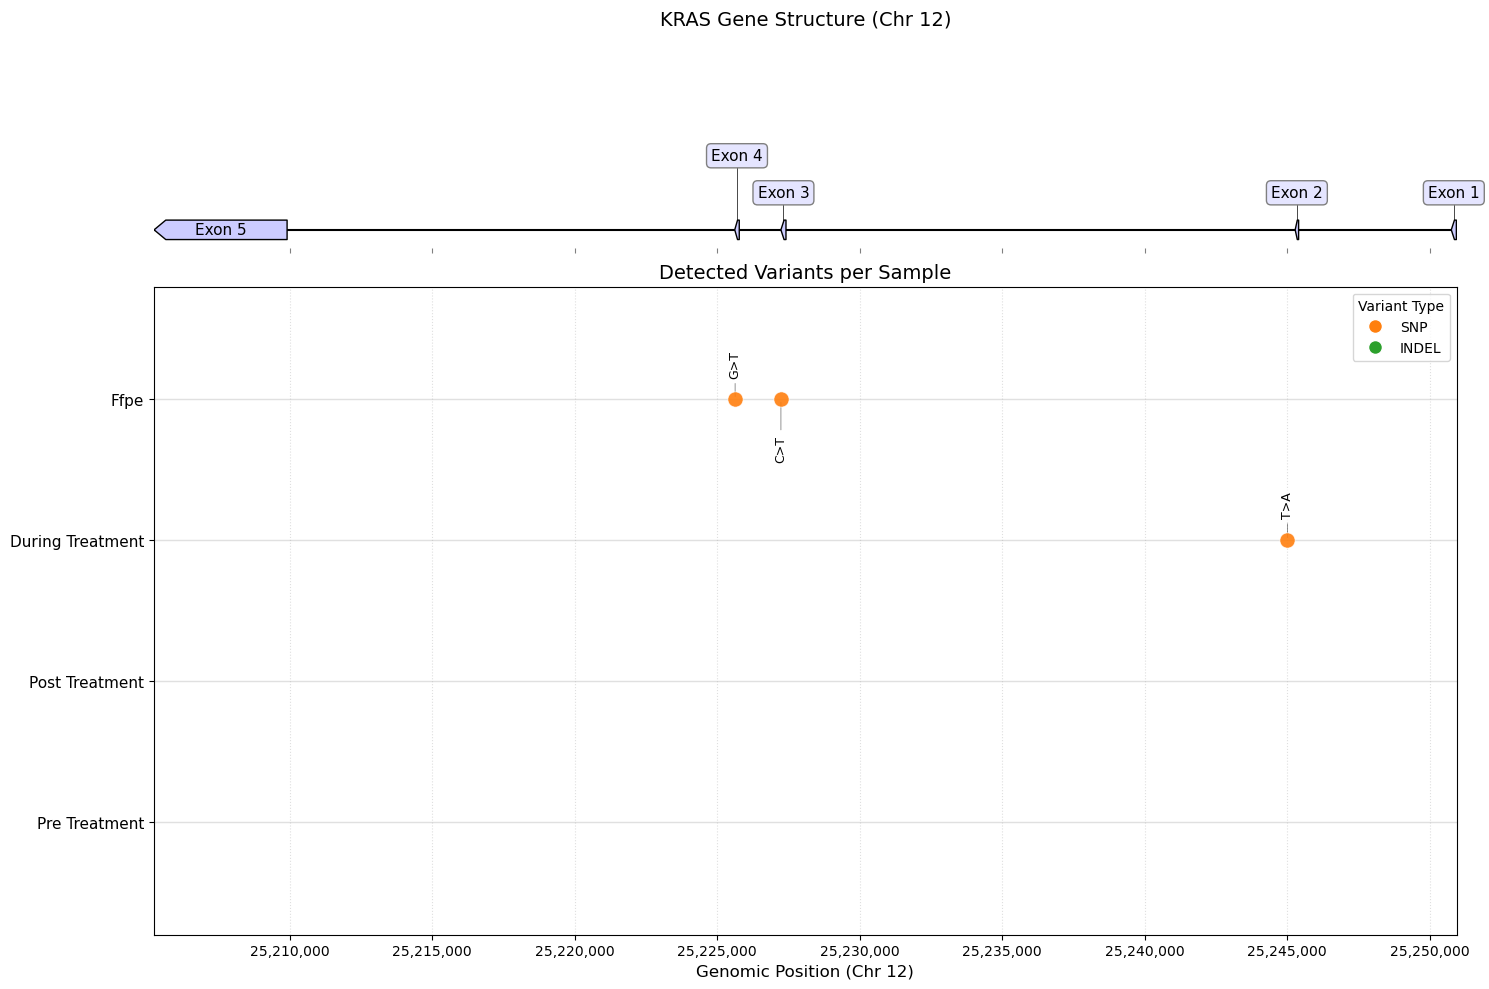

In [20]:
from plots_sequences import plot_protein_mutations, plot_gene_and_variants, get_protein_features

# gff_path is optional. If set to None, the script will automatically fetch gene coordinates from Ensembl.
gff_path = None
# If you have a local GFF file, you can provide it here:
# gff_path = "data/reference/Homo_sapiens.GRCh38.113.chromosome.12.gff3.gz"

variants = plot_gene_and_variants("KRAS", annotated_vcf_paths, fa_ref_genome_path, gff_path=gff_path, genomic_region=kras_genomic_region)

Fetching protein data for KRAS from UniProt API...
UniProt search failed: 400
Generating protein plot for KRAS...
Parsing /Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_pre_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz...
Parsing /Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_post_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz...
Parsing /Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_during_treatment_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz...
Parsing /Users/nzlab-la/Desktop/NGS_biomarker_discovery_toolkit/pipelines_vca/data/vcf/CTC030/CTC030_FFPE_vs_PBMC_somatic_final.snvs.vcf.ann.vcf.gz...
Found variants at positions: [146, 97]
Plot saved to protein_mutations.png


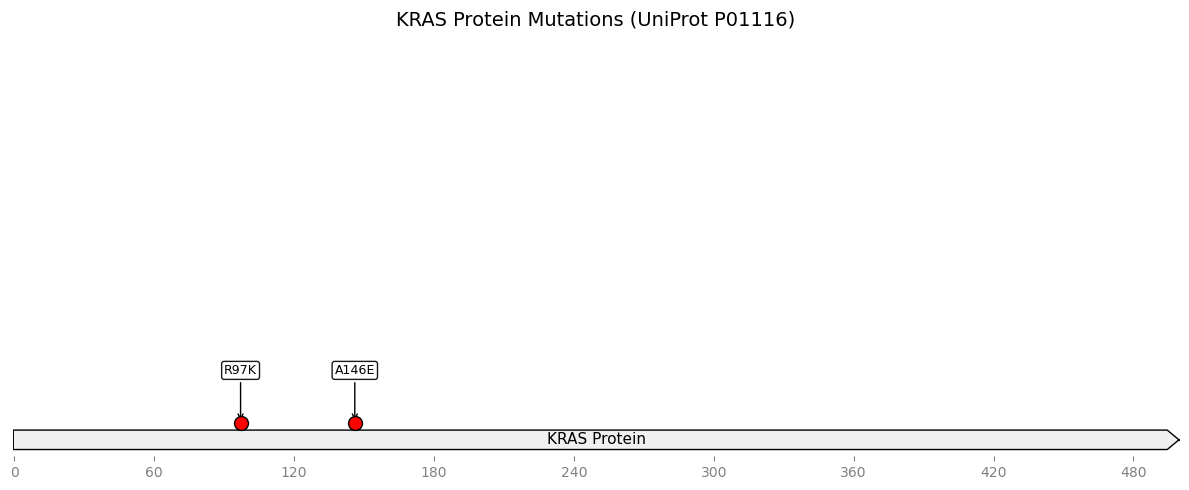

In [21]:
# Visualize Protein Mutations

features, length = get_protein_features("KRAS")
img = plot_protein_mutations("KRAS", annotated_vcf_paths, protein_features=features, protein_length=length)